# 1. Goal: Build a system to identify unreliable/fake news

In [ ]:
from IPython.display import Image
Image(filename="process.png")

#### Dataset used - https://www.kaggle.com/c/fake-news/data

### Dataset Description

train.csv: A full training dataset with the following attributes:

* id: unique id for a news article
* title: the title of a news article
* author: author of the news article
* text: the text of the article; could be incomplete
* label: a label that marks the article as potentially unreliable
  * 1: unreliable
  * 0: reliable

test.csv: A testing training dataset with all the same attributes at train.csv without the label.

submit.csv: A sample submission that you can use to submit your prediction results

# 2. Import required libraries

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#Regular expressions 
import re 

#Natural Language Toolkit
import nltk 
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.tokenize import sent_tokenize, word_tokenize

#Scikit-Learn for modeling
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

import itertools      #required for confusion metrics

The Natural Language Toolkit (NLTK) is a platform used for building Python programs that work with human language data for applying in statistical natural language processing (NLP). It contains text processing libraries for tokenization, parsing, classification, stemming, tagging and semantic reasoning.

Stopwords are words which occur frequently in a corpus. e.g a, an, the, in. Frequently occurring words are removed from the corpus for the purpose of text-normalization.

In [ ]:
#Download the stopwords and tokenizer 

nltk.download('')        #stopwords
nltk.download('')        #punkt

In [ ]:
# Printing the stopwords in English
print(stopwords.words('english'))

# 3. Data Pre-processing and Analysis

#### Typically, we follow below standard steps from text pre-processing and feature engineering standpoint

In [ ]:
from IPython.display import Image
Image(filename="featureengg.png")

## 3.1 Load the dataset, Read and Parse Text

In [ ]:
# First let's load the dataset
news_dataset = pd.read_csv('train_sm.csv')

In [ ]:
#Let's peek into the data
news_dataset.sample()

In [ ]:
# No of articles?
news_dataset.shape

In [ ]:
# Checking for missing values
news_dataset.isnull().sum()

In [ ]:
# Let's replace the missing values with empty strings wherever possible
# news_dataset = news_dataset.fillna('')

In [ ]:
# We will use all text fields such as Title, Author & text description to train our model 
# to help predict if it is real or unreliable news
news_dataset['text_corpus'] = news_dataset['title']+' '+news_dataset['author']+''+news_dataset['text']

In [ ]:
print(news_dataset['text_corpus'])

In [ ]:
news_dataset.head()

In [ ]:
# Now we will separate the data and label i.e. text_corpus and label fields
X = news_dataset.drop(columns='label', axis=1)
Y = news_dataset['label']

In [68]:
X = news_dataset['text_corpus']
X.head()

0    House Dem Aide: We Didn’t Even See Comey’s Let...
1    FLYNN: Hillary Clinton, Big Woman on Campus - ...
2    Why the Truth Might Get You Fired Consortiumne...
3    15 Civilians Killed In Single US Airstrike Hav...
4    Iranian woman jailed for fictional unpublished...
Name: text_corpus, dtype: object

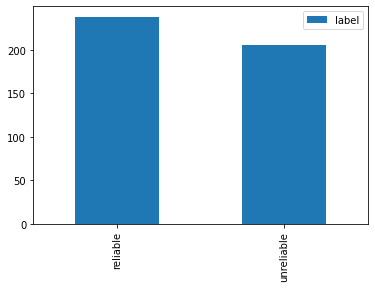

In [90]:
#Whats the split of the types of articles

d = news_dataset['label'].value_counts()
df = pd.DataFrame(data=d)

ax = df.plot.bar()
ax.set_xticks(df.index)
ax.set_xticklabels(["reliable", "unreliable"], rotation=90)
plt.show()

## 3.2 Remove Special Characters 

- Pick all alphabet characters - lowercase and uppercase...all others such as numbers and punctuations will be removed.
- Numbers or punctuations will be replaced by a whitespace

## 3.3 Remove Stopwords

- Remove standard english stopwords

## 3.4 Stemming or Lemmatization

- Here we will try to apply stemming - objective is to reduce the word to it's root word.
- For example: actor, actress, acting, action --> act

In [ ]:
## initialise the inbuilt Stemmer and the Lemmatizer
#stemmer = PorterStemmer()

#For lemmetization you can use this 
#wordnet_lemmatizer = WordNetLemmatizer()

def preprocess(document):
    'changes document to lower case, removes stopwords and stems the remainder of the sentence'
    
    # Pick all alphabet characters - lowercase and uppercase...all others such as numbers and punctuations will be removed. Numbers or punctuations will be replaced by a whitespace
    document = re.sub('[^a-zA-Z]',' ', str(document))
    
    # change sentence to lower case
    document = document.lower()

    # tokenize into words
    words = document.split()

    # stem the words and remove stop words
    words = [stemmer.stem(word) for word in words if not word in stopwords.words('english')]

    # join words to make sentence
    stemmed_content = " ".join(words)

    return stemmed_content

In [ ]:
#Let's see what preprocess does to the text.
preprocess(X[0])

In [ ]:
# Apply the function to all the rows. This may take a while to execute
news_dataset['BOW'] = X.apply(preprocess)

In [ ]:
print(news_dataset['BOW'][:5])

In [ ]:
# Separating data and label
X = news_dataset['BOW'].values
Y = news_dataset['label'].values

In [ ]:
print(X[0])
print(Y[0])

## 3.5 TF-IDF (Term Frequency, Inverse Document Frequency)

### Converting Textual data to Numerical data

* We will use TF-IDF Vectorizer
* TF-IDF Vectorizer will convert textual data to numerical data

In [ ]:
#Use the sklearn TFidf vectorizer 

vectorizer = TfidfVectorizer()
vectorizer.fit(X)

X = vectorizer.transform(X)

In [ ]:
print(X)

# 4. Modeling & Model Evaluation

### Splitting the data into test and train datasets

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.20, stratify=Y, random_state=123)

### Training the model (model1 : Logistic Regression)

In [ ]:
# Training a simple model
lrmodel = LogisticRegression()

#lrmodel.fit(X_train, Y_train)

### Model Evaluation

In [ ]:
# Accuracy Score on Training Data
X_train_prediction = lrmodel.predict(X_train)
training_data_accuracy = accuracy_score(X_train_prediction, Y_train)

print('Accuracy score on the training data: ',training_data_accuracy)

# Accuracy Score on Test Data
X_test_prediction = lrmodel.predict(X_test)
test_data_accuracy = accuracy_score(X_test_prediction, Y_test)

print('Accuracy score on the test data: ',test_data_accuracy)

In [ ]:
# Function to plot confusion Matrix
def plot_confusion_matrix(cm, 
                          classes,
                          normalize=False,
                          title='Confusion Matrix',
                          cmap=plt.cm.Blues):
  plt.imshow(cm, interpolation='nearest', cmap=cmap)
  plt.title(title)
  plt.colorbar()
  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes, rotation=45)
  plt.yticks(tick_marks, classes)
  
  if normalize:
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    print("Normalized confusion matrix")
  else:
      print('Confusion matrix, without normalization')
  thresh = cm.max() / 2.
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
      plt.text(j, i, cm[i, j],horizontalalignment="center",color="white" if cm[i, j] > thresh else "black")
  plt.tight_layout()
  plt.ylabel('True label')
  plt.xlabel('Predicted label')

In [ ]:
cm = confusion_matrix(Y_test, X_test_prediction)
plot_confusion_matrix(cm, classes=['Unreliable', 'Reliable'])

In [ ]:
# Classification report for test data
classification_report(Y_test, X_test_prediction)

In [ ]:
# Training a Random forest Classifier model
rfmodel =                             # Use the RandomForestClassifier with 500 trees
rfmodel.fit(X_train, Y_train)

# Accuracy Score on Test Data
X_test_prediction = rfmodel.predict(X_test)
test_data_accuracy = accuracy_score(X_test_prediction, Y_test)

print('Accuracy score on the test data: ',test_data_accuracy)

cm = confusion_matrix(Y_test, X_test_prediction)
plot_confusion_matrix(cm, classes=['Unreliable', 'Reliable'])

# 5. Making a Prediction

In [ ]:
# Load the test dataset

test_dataset = pd.read_csv('test.csv')

test_dataset['text_corpus'] = test_dataset['title']+' '+test_dataset['author']+''+test_dataset['text']
test_dataset['BOW'] = test_dataset['text_corpus'].apply(preprocess)

X_text = vectorizer.transform(test_dataset['BOW'])

prediction = lrmodel.predict(X_text)

In [ ]:
test_dataset['prediction'] = prediction
test_dataset

In [ ]:
print(Y_test[100])

***